In [1]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [2]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [3]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print(np.sqrt(mse))

36.271203581682585


In [5]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

### Binary classification

In [6]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

print(confusion_matrix(y, y_pred))

[[212   0]
 [  0 357]]


### Multiclass classification

In [7]:
wine = load_wine()

X = wine.data
y = wine.target

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

print(confusion_matrix(y, y_pred))

[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]


### Cross validation

In [8]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(mean_squared_error(y_test, y_pred))
    
display_scores(np.sqrt(scores))

Scores: [55.30444573 55.59151472 63.44642064 57.82986083 58.71808276]
Mean: 58.178
Std: 2.937


In [9]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=5)

display_scores(np.sqrt(-scores))

Scores: [56.04057166 56.14039793 60.3213523  59.67532995 60.7722925 ]
Mean: 58.590
Std: 2.071


### Hyperparameter searching

In [10]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)


params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model with rank: 1
Mean validation score: 0.471 (std: 0.003)
Parameters: {'colsample_bytree': 0.9521318895941269, 'gamma': 0.45534309912785653, 'learning_rate': 0.06684323455372013, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.6662082041469158}



[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   35.5s finished
/Users/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

# if more than one evaluation metric are given the last one is used for early stopping
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.964315
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.970662
[2]	validation_0-auc:0.976176
[3]	validation_0-auc:0.976176
[4]	validation_0-auc:0.977216
[5]	validation_0-auc:0.977008
[6]	validation_0-auc:0.97732
[7]	validation_0-auc:0.97732
[8]	validation_0-auc:0.973575
[9]	validation_0-auc:0.973575
[10]	validation_0-auc:0.973575
[11]	validation_0-auc:0.973575
Stopping. Best iteration:
[6]	validation_0-auc:0.97732



0.958041958041958

- xgb_model.fit() will produce a model from the last iteration, not the best one, so to get the optimum model consider retraining over xgb_model.best_iteration rounds.

In [17]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

best score: 0.97732, best iteration: 6, best ntree limit 7


### Evaluations

In [18]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error", "error@0.6"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

[0]	validation_0-auc:0.964315	validation_0-error:0.048951	validation_0-error@0.6:0.622378
[1]	validation_0-auc:0.970662	validation_0-error:0.048951	validation_0-error@0.6:0.622378
[2]	validation_0-auc:0.976176	validation_0-error:0.041958	validation_0-error@0.6:0.104895
[3]	validation_0-auc:0.976176	validation_0-error:0.041958	validation_0-error@0.6:0.076923
[4]	validation_0-auc:0.977216	validation_0-error:0.041958	validation_0-error@0.6:0.062937
[5]	validation_0-auc:0.977008	validation_0-error:0.041958	validation_0-error@0.6:0.062937
[6]	validation_0-auc:0.97732	validation_0-error:0.041958	validation_0-error@0.6:0.055944
[7]	validation_0-auc:0.97732	validation_0-error:0.048951	validation_0-error@0.6:0.048951
[8]	validation_0-auc:0.973575	validation_0-error:0.048951	validation_0-error@0.6:0.048951
[9]	validation_0-auc:0.973575	validation_0-error:0.048951	validation_0-error@0.6:0.048951
[10]	validation_0-auc:0.973575	validation_0-error:0.048951	validation_0-error@0.6:0.048951
[11]	valida

### Plotting

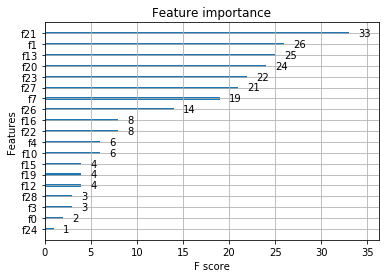

In [20]:
# requires graphviz and python-graphviz conda packages
import graphviz

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(xgb_model)



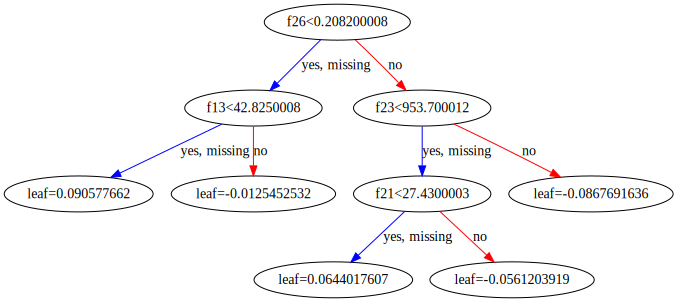

In [21]:
# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)